# MPPT Data Stitching and Analysis

This notebook combines multiple MPPT trial CSV files into a single continuous time series dataset and provides visualization capabilities.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import re
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style for better plots
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

## Enhanced MPPT Data Stitching Function

In [2]:
def discover_mppt_files(data_directory):
    """
    Automatically discover and sort MPPT CSV files by timestamp.

    Args:
        data_directory (str): Path to directory containing CSV files

    Returns:
        list: Sorted list of file paths
    """
    # Find all CSV files in the directory
    csv_files = glob.glob(os.path.join(data_directory, "*.csv"))

    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_directory}")

    # Extract timestamps from filenames and sort
    file_timestamps = []
    for file_path in csv_files:
        filename = os.path.basename(file_path)
        # Extract timestamp from filename (assuming format: Jul-30-2025_13-44-33__ID1__compressedmppt.csv)
        timestamp_match = re.match(r'([A-Za-z]{3}-\d{2}-\d{4}_\d{2}-\d{2}-\d{2})', filename)
        if timestamp_match:
            timestamp_str = timestamp_match.group(1)
            try:
                # Parse the timestamp
                timestamp = datetime.strptime(timestamp_str, '%b-%d-%Y_%H-%M-%S')
                file_timestamps.append((timestamp, file_path))
            except ValueError:
                print(f"Warning: Could not parse timestamp from {filename}")
                file_timestamps.append((datetime.min, file_path))
        else:
            print(f"Warning: Could not extract timestamp from {filename}")
            file_timestamps.append((datetime.min, file_path))

    # Sort by timestamp
    file_timestamps.sort(key=lambda x: x[0])
    sorted_files = [file_path for timestamp, file_path in file_timestamps]

    print(f"Found {len(sorted_files)} CSV files:")
    for i, file_path in enumerate(sorted_files):
        print(f"  {i+1}. {os.path.basename(file_path)}")

    return sorted_files

In [3]:
def load_and_validate_mppt_file(file_path):
    """
    Load a single MPPT CSV file and extract metadata and data.

    Args:
        file_path (str): Path to CSV file

    Returns:
        tuple: (metadata, headers, data_array)
    """
    print(f"Loading {os.path.basename(file_path)}...")

    # Load the file as string array
    arr = np.loadtxt(file_path, delimiter=",", dtype=str)

    # Find the header row (contains "Time")
    header_row_idx = np.where(arr == "Time")[0]
    if len(header_row_idx) == 0:
        raise ValueError(f"No 'Time' column found in {file_path}")

    header_row = header_row_idx[0]

    # Extract components
    headers = arr[header_row, :]
    metadata = arr[:header_row + 1, :]
    data = arr[header_row + 1:, :]

    # Convert data to appropriate types
    data_numeric = data.astype(float)

    print(f"  - Data shape: {data_numeric.shape}")
    print(f"  - Time range: {data_numeric[0, 0]:.1f} to {data_numeric[-1, 0]:.1f} seconds")

    return metadata, headers, data_numeric

In [4]:
def stitch_mppt_files(file_paths, output_filename=None):
    """
    Stitch multiple MPPT CSV files into a continuous time series.

    Args:
        file_paths (list): List of file paths to stitch
        output_filename (str): Optional output filename

    Returns:
        tuple: (combined_metadata, headers, combined_data)
    """
    if not file_paths:
        raise ValueError("No files provided")

    print(f"\nStitching {len(file_paths)} files...")

    combined_data_list = []
    cumulative_time = 0.0
    reference_metadata = None
    reference_headers = None

    for i, file_path in enumerate(file_paths):
        metadata, headers, data = load_and_validate_mppt_file(file_path)

        # Store reference metadata and headers from first file
        if i == 0:
            reference_metadata = metadata
            reference_headers = headers
        else:
            # Validate headers match
            if not np.array_equal(headers, reference_headers):
                print(f"Warning: Headers in {os.path.basename(file_path)} don't match reference")

        # Adjust time column (assuming Time is in first column)
        if i > 0:
            # Add offset to make time continuous
            data[:, 0] += cumulative_time

        # Update cumulative time for next file
        cumulative_time = data[-1, 0]

        combined_data_list.append(data)

        print(f"  File {i+1}: {data.shape[0]} data points, time range: {data[0, 0]:.1f} to {data[-1, 0]:.1f} s")

    # Combine all data
    combined_data = np.vstack(combined_data_list)

    print(f"\nCombined dataset:")
    print(f"  - Total data points: {combined_data.shape[0]}")
    print(f"  - Total time span: {combined_data[-1, 0]:.1f} seconds ({combined_data[-1, 0]/3600:.2f} hours)")
    print(f"  - Columns: {len(reference_headers)}")

    # Save combined file if requested
    if output_filename:
        save_combined_data(reference_metadata, reference_headers, combined_data, output_filename)

    return reference_metadata, reference_headers, combined_data

In [5]:
def save_combined_data(metadata, headers, data, output_filename):
    """
    Save the combined data to a CSV file.

    Args:
        metadata (np.array): Metadata from original files
        headers (np.array): Column headers
        data (np.array): Combined numeric data
        output_filename (str): Output filename
    """
    # Convert data back to string format for saving
    data_str = data.astype(str)

    # Combine metadata, headers, and data
    full_array = np.vstack([metadata, data_str])

    # Save to file
    np.savetxt(output_filename, full_array, delimiter=',', fmt='%s')

    print(f"\nCombined data saved to: {output_filename}")
    print(f"File size: {os.path.getsize(output_filename) / (1024*1024):.2f} MB")

## Data Analysis and Visualization Functions

In [6]:
def analyze_solar_cells(headers, data):
    """
    Analyze the solar cell data and create summary statistics.

    Args:
        headers (np.array): Column headers
        data (np.array): Combined data array

    Returns:
        dict: Analysis results
    """
    header_dict = {value: index for index, value in enumerate(headers)}

    # Find pixel columns
    pixel_columns = {}
    for i in range(1, 9):  # Pixel_1 through Pixel_8
        v_col = f"Pixel_{i} V"
        i_col = f"Pixel_{i} mA"
        if v_col in header_dict and i_col in header_dict:
            pixel_columns[f"Pixel_{i}"] = {
                'voltage': header_dict[v_col],
                'current': header_dict[i_col]
            }

    print(f"\nFound {len(pixel_columns)} solar cells:")

    analysis = {
        'time': data[:, header_dict['Time']],
        'pixels': {},
        'summary': {}
    }

    for pixel_name, cols in pixel_columns.items():
        voltage = data[:, cols['voltage']]
        current = data[:, cols['current']] / 1000  # Convert mA to A
        power = voltage * current * 1000  # Power in mW

        pixel_stats = {
            'voltage': voltage,
            'current': current,
            'power': power,
            'avg_voltage': np.mean(voltage),
            'avg_current': np.mean(current),
            'avg_power': np.mean(power),
            'max_power': np.max(power),
            'min_power': np.min(power)
        }

        analysis['pixels'][pixel_name] = pixel_stats

        print(f"  {pixel_name}: Avg V={pixel_stats['avg_voltage']:.3f}V, "
              f"Avg I={pixel_stats['avg_current']:.3f}A, Avg P={pixel_stats['avg_power']:.2f}mW")

    return analysis

In [7]:
def plot_time_series(analysis, plot_type='voltage', save_plots=False):
    """
    Create time series plots for all solar cells.

    Args:
        analysis (dict): Analysis results from analyze_solar_cells
        plot_type (str): 'voltage', 'current', or 'power'
        save_plots (bool): Whether to save plots to files
    """
    time_hours = analysis['time'] / 3600  # Convert to hours

    plt.figure(figsize=(15, 10))

    colors = plt.cm.tab10(np.linspace(0, 1, 8))

    for i, (pixel_name, pixel_data) in enumerate(analysis['pixels'].items()):
        if plot_type == 'voltage':
            y_data = pixel_data['voltage']
            ylabel = 'Voltage (V)'
            title = 'Solar Cell Voltage vs Time'
        elif plot_type == 'current':
            y_data = pixel_data['current'] * 1000  # Convert back to mA for display
            ylabel = 'Current (mA)'
            title = 'Solar Cell Current vs Time'
        elif plot_type == 'power':
            y_data = pixel_data['power']
            ylabel = 'Power (mW)'
            title = 'Solar Cell Power vs Time'
        else:
            raise ValueError(f"Unknown plot_type: {plot_type}")

        plt.plot(time_hours, y_data, label=pixel_name, color=colors[i], linewidth=1)

    plt.xlabel('Time (hours)')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_plots:
        plt.savefig(f'mppt_timeseries_{plot_type}.png', dpi=300, bbox_inches='tight')
        print(f"Plot saved as: mppt_timeseries_{plot_type}.png")

    plt.show()

In [8]:
def plot_power_comparison(analysis, save_plots=False):
    """
    Create a comparison plot showing average power for each solar cell.

    Args:
        analysis (dict): Analysis results from analyze_solar_cells
        save_plots (bool): Whether to save plots to files
    """
    pixel_names = list(analysis['pixels'].keys())
    avg_powers = [analysis['pixels'][name]['avg_power'] for name in pixel_names]
    max_powers = [analysis['pixels'][name]['max_power'] for name in pixel_names]
    min_powers = [analysis['pixels'][name]['min_power'] for name in pixel_names]

    x = np.arange(len(pixel_names))
    width = 0.35

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot of average powers
    bars = ax1.bar(x, avg_powers, width, alpha=0.8, color='steelblue')
    ax1.set_xlabel('Solar Cell')
    ax1.set_ylabel('Average Power (mW)')
    ax1.set_title('Average Power Output by Solar Cell')
    ax1.set_xticks(x)
    ax1.set_xticklabels(pixel_names, rotation=45)
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for bar, power in zip(bars, avg_powers):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                f'{power:.1f}', ha='center', va='bottom')

    # Error bar plot showing min/max range
    ax2.errorbar(x, avg_powers,
                yerr=[np.array(avg_powers) - np.array(min_powers),
                      np.array(max_powers) - np.array(avg_powers)],
                fmt='o', capsize=5, capthick=2, color='red', markersize=8)
    ax2.set_xlabel('Solar Cell')
    ax2.set_ylabel('Power (mW)')
    ax2.set_title('Power Range (Min/Avg/Max) by Solar Cell')
    ax2.set_xticks(x)
    ax2.set_xticklabels(pixel_names, rotation=45)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_plots:
        plt.savefig('mppt_power_comparison.png', dpi=300, bbox_inches='tight')
        print("Plot saved as: mppt_power_comparison.png")

    plt.show()

## Main Execution Script

In [17]:
# Configuration
DATA_DIRECTORY = r"C:\Users\achen\Dropbox\code\Stability-Setup\data\Jul-30-2025 13_43_35_compressed"
OUTPUT_FILENAME = "combined_mppt_data.csv"
SAVE_PLOTS = True

print("=== MPPT Data Stitching and Analysis ===")
print(f"Data directory: {DATA_DIRECTORY}")
print(f"Output file: {OUTPUT_FILENAME}")

=== MPPT Data Stitching and Analysis ===
Data directory: C:\Users\achen\Dropbox\code\Stability-Setup\data\Jul-30-2025 13_43_35_compressed
Output file: combined_mppt_data.csv


In [18]:
# Step 1: Discover files
try:
    mppt_files = discover_mppt_files(DATA_DIRECTORY)
except Exception as e:
    print(f"Error discovering files: {e}")
    mppt_files = None

Found 5 CSV files:
  1. Jul-30-2025_13-44-33__ID1__compressedmppt.csv
  2. Jul-30-2025_18-45-51__ID1__compressedmppt.csv
  3. Jul-30-2025_23-47-09__ID1__compressedmppt.csv
  4. Jul-31-2025_04-48-26__ID1__compressedmppt.csv
  5. Jul-31-2025_09-49-44__ID1__compressedmppt.csv


In [19]:
# Step 2: Stitch files together
if mppt_files:
    try:
        metadata, headers, combined_data = stitch_mppt_files(mppt_files, OUTPUT_FILENAME)
        print("\n✓ Files successfully stitched together!")
    except Exception as e:
        print(f"Error stitching files: {e}")
        combined_data = None
else:
    combined_data = None


Stitching 5 files...
Loading Jul-30-2025_13-44-33__ID1__compressedmppt.csv...
  - Data shape: (539, 18)
  - Time range: 17.5 to 17996.6 seconds
  File 1: 539 data points, time range: 17.5 to 17996.6 s
Loading Jul-30-2025_18-45-51__ID1__compressedmppt.csv...
  - Data shape: (538, 18)
  - Time range: 17.5 to 17988.9 seconds
  File 2: 538 data points, time range: 18014.1 to 35985.5 s
Loading Jul-30-2025_23-47-09__ID1__compressedmppt.csv...
  - Data shape: (538, 18)
  - Time range: 17.5 to 17990.3 seconds
  File 3: 538 data points, time range: 36003.0 to 53975.8 s
Loading Jul-31-2025_04-48-26__ID1__compressedmppt.csv...
  - Data shape: (537, 18)
  - Time range: 17.5 to 17988.7 seconds
  File 4: 537 data points, time range: 53993.3 to 71964.6 s
Loading Jul-31-2025_09-49-44__ID1__compressedmppt.csv...
  - Data shape: (368, 18)
  - Time range: 17.5 to 12285.5 seconds
  File 5: 368 data points, time range: 71982.1 to 84250.1 s

Combined dataset:
  - Total data points: 2520
  - Total time span

In [20]:
# Step 3: Analyze the data
if combined_data is not None:
    try:
        analysis = analyze_solar_cells(headers, combined_data)
        print("\n✓ Data analysis completed!")
    except Exception as e:
        print(f"Error analyzing data: {e}")
        analysis = None
else:
    analysis = None


Found 8 solar cells:
  Pixel_1: Avg V=0.716V, Avg I=0.003A, Avg P=2.04mW
  Pixel_2: Avg V=0.669V, Avg I=0.001A, Avg P=0.59mW
  Pixel_3: Avg V=0.708V, Avg I=0.003A, Avg P=1.88mW
  Pixel_4: Avg V=0.676V, Avg I=0.001A, Avg P=0.88mW
  Pixel_5: Avg V=0.743V, Avg I=0.002A, Avg P=1.27mW
  Pixel_6: Avg V=0.628V, Avg I=0.000A, Avg P=0.02mW
  Pixel_7: Avg V=0.648V, Avg I=0.002A, Avg P=1.39mW
  Pixel_8: Avg V=0.705V, Avg I=0.002A, Avg P=1.73mW

✓ Data analysis completed!



=== Creating Visualizations ===

Plotting voltage time series...
Plot saved as: mppt_timeseries_voltage.png


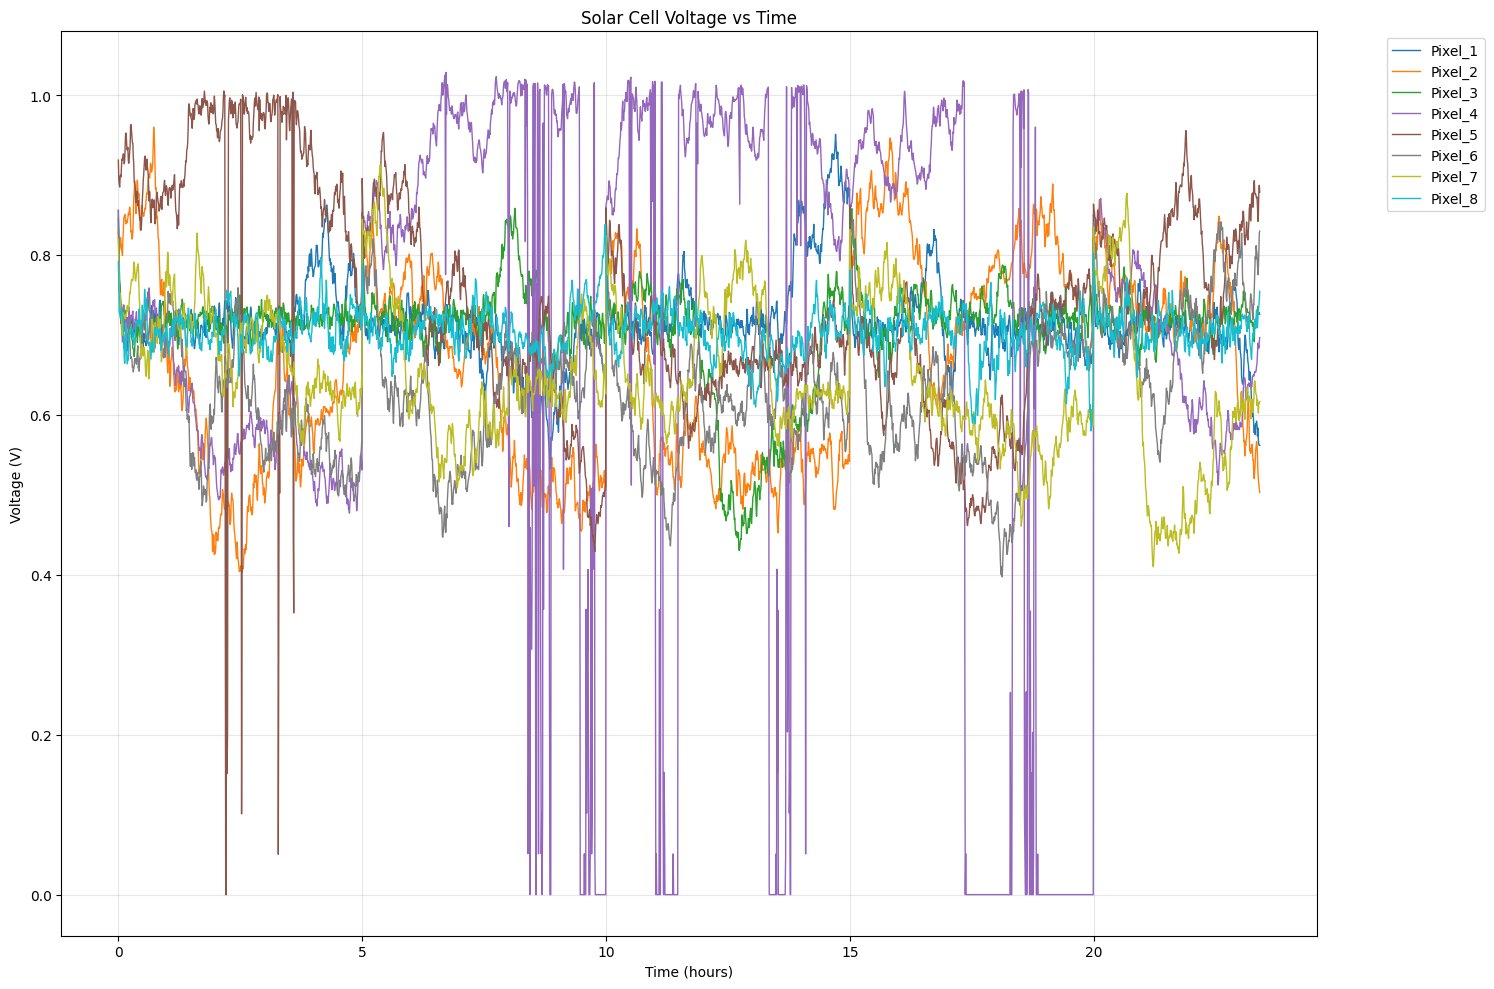

In [21]:
# Step 4: Create visualizations
if analysis:
    print("\n=== Creating Visualizations ===")

    # Voltage time series
    print("\nPlotting voltage time series...")
    plot_time_series(analysis, plot_type='voltage', save_plots=SAVE_PLOTS)


Plotting current time series...
Plot saved as: mppt_timeseries_current.png


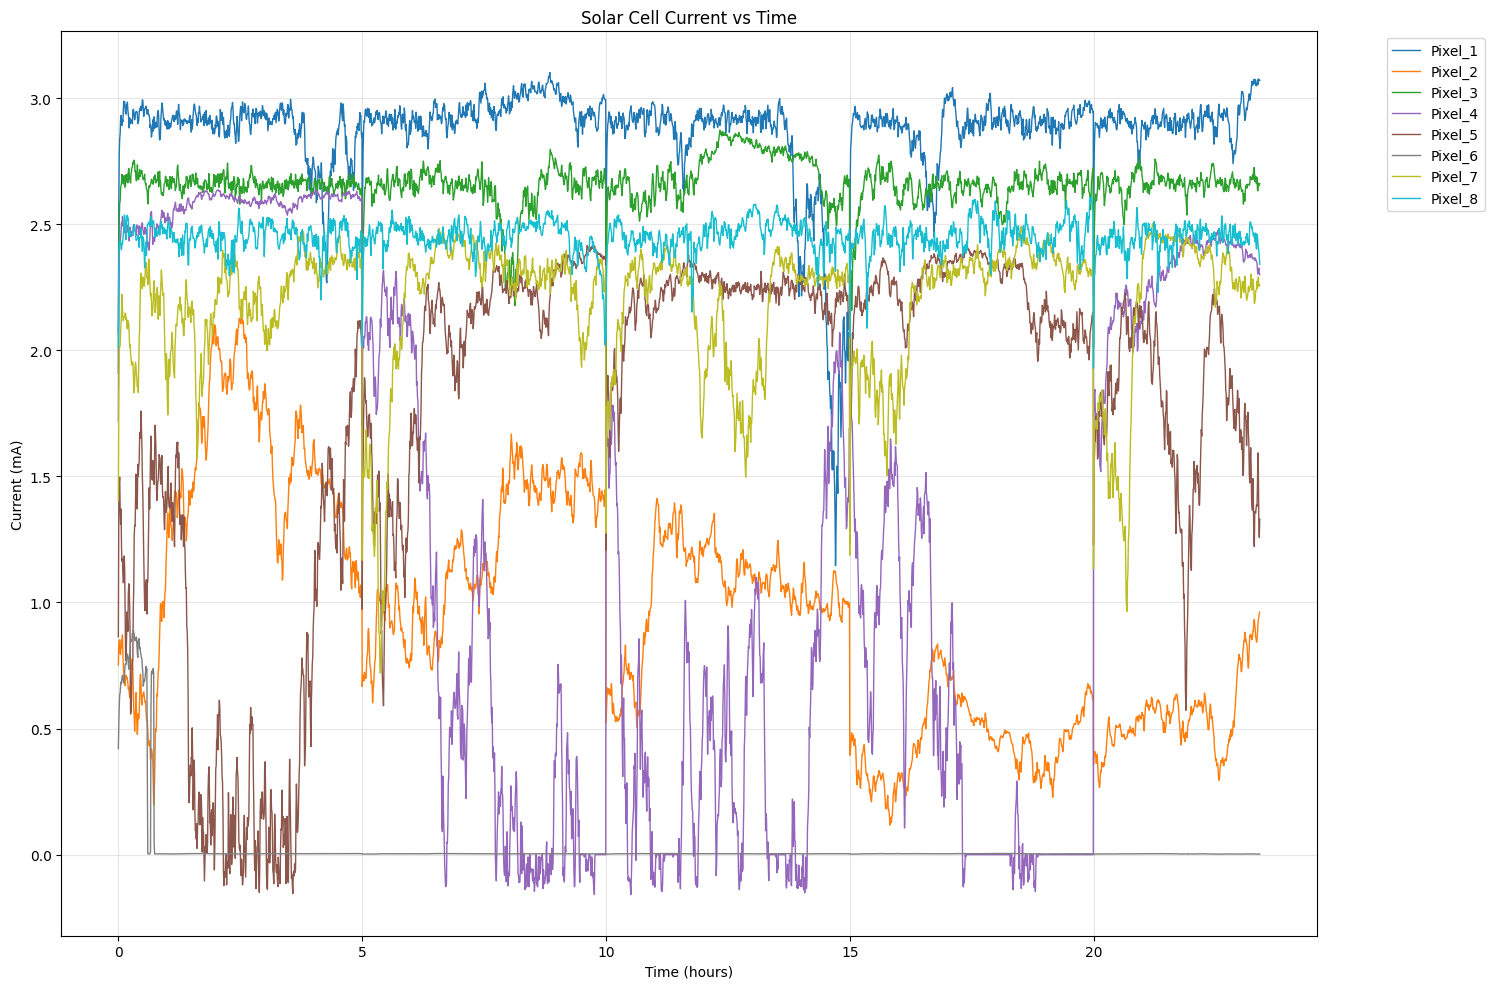

In [22]:
# Current time series
if analysis:
    print("\nPlotting current time series...")
    plot_time_series(analysis, plot_type='current', save_plots=SAVE_PLOTS)


Plotting power time series...
Plot saved as: mppt_timeseries_power.png


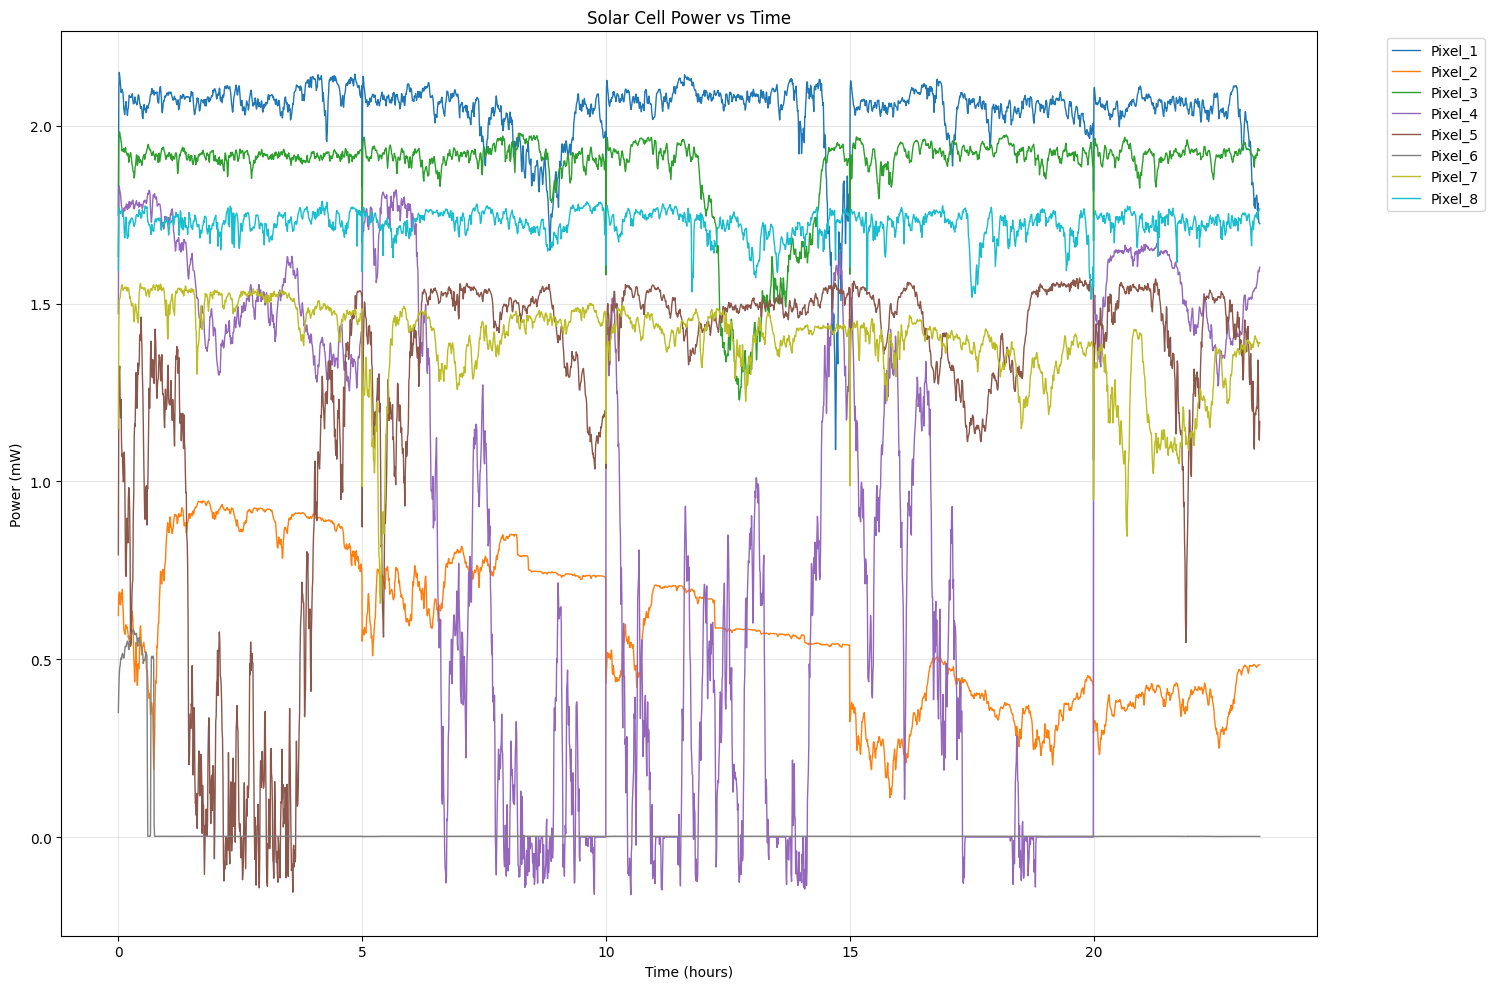

In [23]:
# Power time series
if analysis:
    print("\nPlotting power time series...")
    plot_time_series(analysis, plot_type='power', save_plots=SAVE_PLOTS)

In [16]:
# Power comparison
if analysis:
    print("\nPlotting power comparison...")
    plot_power_comparison(analysis, save_plots=SAVE_PLOTS)

    print("\n✓ All visualizations completed!")
    print(f"\n=== Summary ===")
    print(f"Total data points: {combined_data.shape[0]:,}")
    print(f"Total measurement time: {combined_data[-1, 0]/3600:.2f} hours")
    print(f"Solar cells analyzed: {len(analysis['pixels'])}")
    print(f"Combined data saved to: {OUTPUT_FILENAME}")
    if SAVE_PLOTS:
        print("All plots saved as PNG files.")